In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [ ]:
# Handle Git Conflict Markers and Load Data
try:
    with open('dirty_cafe_sales.csv', 'r') as f:
        lines = f.readlines()
    
    # Filter out lines starting with git markers
    filtered_lines = [line for line in lines if not line.startswith(('<<<<<<<', '=======', '>>>>>>>'))]
    
    with open('temp_clean_input.csv', 'w') as f:
        f.writelines(filtered_lines)
    
    df = pd.read_csv('temp_clean_input.csv')
    df.columns = df.columns.str.strip() # Clean column names
    print(f"Dataset loaded. Initial Shape: {df.shape}")
except Exception as e:
    print(f"Error: {e}")

# Replace 'ERROR' and 'UNKNOWN' with NaN as per proposal
df.replace(['ERROR', 'UNKNOWN'], np.nan, inplace=True)

# Drop duplicates
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

Dataset loaded. Initial Shape: (20001, 8)
Shape after removing duplicates: (10001, 8)


In [12]:
# Convert data types to numeric/datetime
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Handle missing values using Median (Numerical) and Mode (Categorical)
for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    df[col] = df[col].fillna(df[col].median())

for col in ['Item', 'Payment Method', 'Location']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Feature Engineering: Extracting Date Features
df['Transaction Date'] = df['Transaction Date'].fillna(df['Transaction Date'].mode()[0])
df['Day'] = df['Transaction Date'].dt.day
df['Month'] = df['Transaction Date'].dt.month
df['Weekday'] = df['Transaction Date'].dt.weekday

print("Preprocessing complete. Missing values remaining:", df.isnull().sum().sum())

Preprocessing complete. Missing values remaining: 0


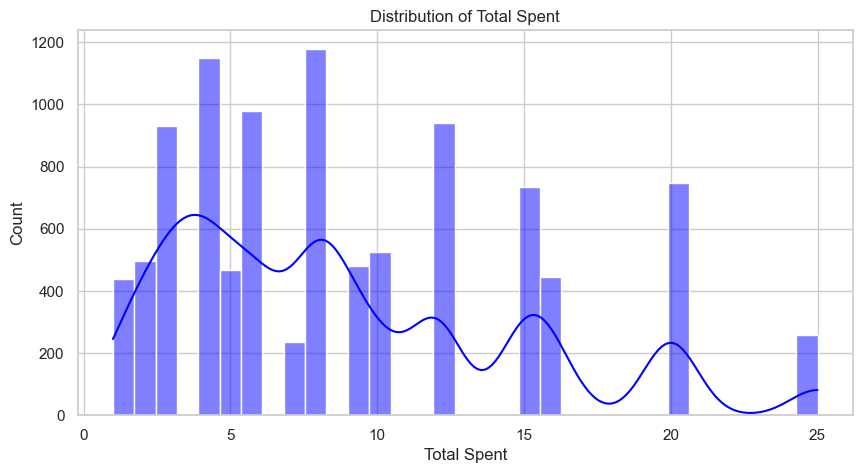

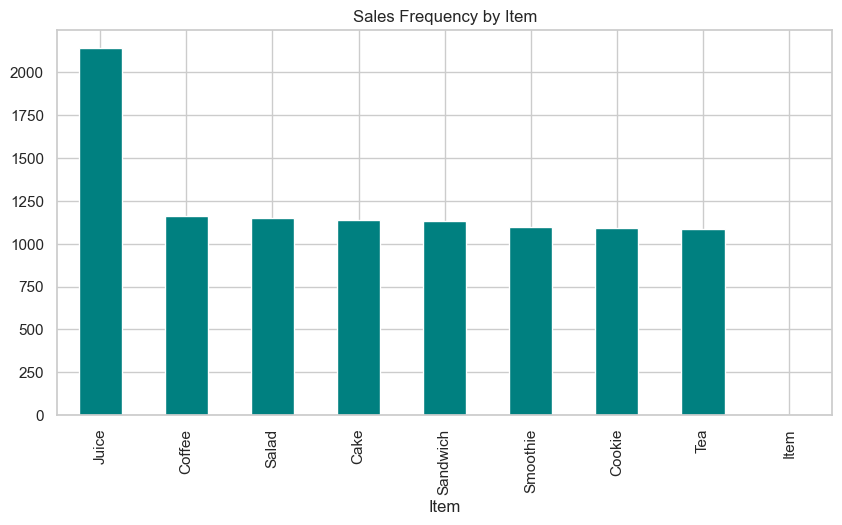

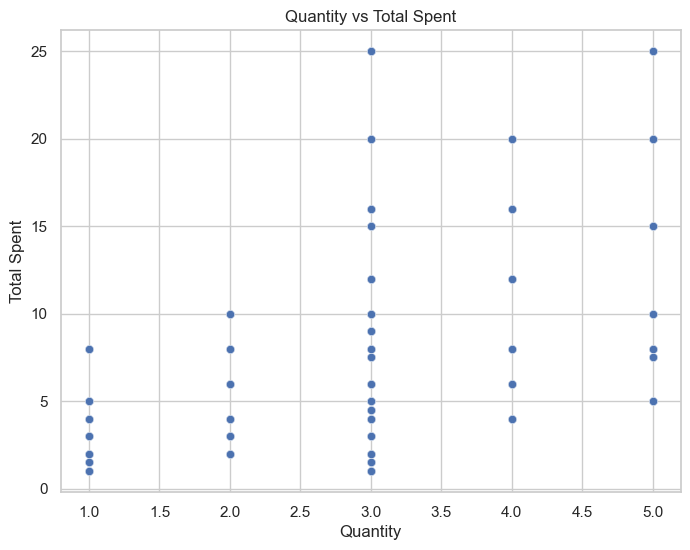

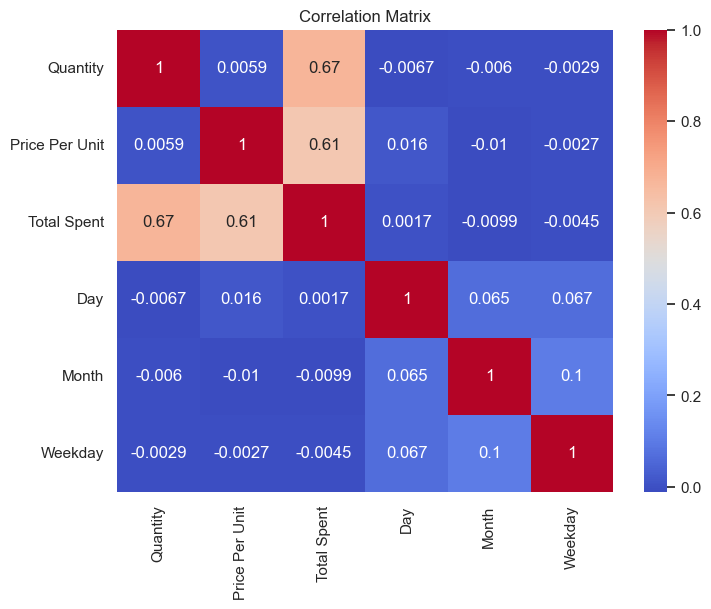

In [ ]:
# Distribution of Total Spent
plt.figure(figsize=(10, 5))
sns.histplot(df['Total Spent'], kde=True, color='blue')
plt.title('Distribution of Total Spent')
plt.show()

# Sales by Item
plt.figure(figsize=(10, 5))
df['Item'].value_counts().plot(kind='bar', color='teal')
plt.title('Sales Frequency by Item')
plt.show()

# Relationship between Quantity and Total Spent
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Quantity', y='Total Spent', alpha=0.5)
plt.title('Quantity vs Total Spent')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()